Alan Soby 201687565 </br>
Asma Nasir 201322030 </br>
Naveen Baburaj 201665419 </br>
Li Yang Alphonsus Ho 201669440 </br> </br>

### Assignment 2

Implementation of a deep reinforcement learning method for Lunar Lander

Classes: </br>
Lunar </br>
    Class that models the Environment the agent is participating in.
    Source of rewards </br> </br>
Agent </br>
    Interacts with the environment to maximise rewards </br>
</br>
Methods: </br>
train() </br>
    Execute the agent training process to achieve the goal </br>
    End goal of rewards more than or equal to 200 </br>

In [ ]:
!pip install gymnasium
!pip install gym[all]
!pip install box2d
!pip install box2d box2d-kengz
!pip install pyvirtualdisplay
!apt-get install xvfb

import pyvirtualdisplay
d = pyvirtualdisplay.Display()
d.start() # Start Xvfb and set "DISPLAY" environment properly.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 28.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Importing the libaries
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import Huber, MSE
from collections import deque, namedtuple

tf.random.set_seed(0)

### Creating a Lunar environment

In [ ]:
class Lunar:

    def __init__(self, memorySize, stateSpace, actionSpace, batchSize):

        self.env = gym.make("LunarLander-v2")
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.event = namedtuple("Experience", field_names=["state", "action", "reward", "nextState", "done"])
        self.memoryBuffer = deque(range(memorySize))
        self.batchSize = batchSize

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def selectActions(self, qValues, eps):
        if random.random() > eps:
            return np.argmax(qValues.numpy()[0])
        else:
            return random.choice(np.arange(self.actionSpace))

    def updateFlag(self, currentStep, stepUpdate, memoryBuffer):
        # Ensures model not updated too frequently
        # Ensure buffer greater than batchsize such that enough experience to sample from for training
        if(currentStep+1) % stepUpdate == 0 and len(memoryBuffer) > self.batchSize:
            return True
        else:
            return False

    def getEvent(self, events):
        # Extract the states, actions, rewards, nextStates, and dones from a list of events
        # Only extract the values for non-None events
        states = tf.convert_to_tensor(np.array([e.state for e in events if e is not None]),dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array([e.action for e in events if e is not None]), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array([e.reward for e in events if e is not None]), dtype=tf.float32)
        nextStates = tf.convert_to_tensor(np.array([e.nextState for e in events if e is not None]),dtype=tf.float32)

        # Indicates if the episode is over or not
        dones = tf.convert_to_tensor(np.array([e.done for e in events if e is not None]).astype(np.uint8), dtype=tf.float32)

        return (states, actions, rewards, nextStates, dones)

#### 2 loss functions are tested, Huber and MSE loss. The following cells are to determine which of the loss functions allows the agent to achieve the goal in the shortest number of episodes possible

### Executing the program using Huber Loss

In [ ]:
# Huber Loss
class Agent:

    def __init__(self, alpha, gamma, stepUpdate, stateSpace, actionSpace, batchSize, epsMin, epsDecay, softUpdate):

        self.optimizer = Adam(learning_rate=alpha)
        self.gamma = gamma
        self.stepUpdate = stepUpdate
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.batchSize = batchSize
        self.hiddenActivation = "relu"
        self.outputActivation = "linear"
        self.model, self.targetModel = self._createModels()
        self.targetModel.set_weights(self.model.get_weights())
        self.epsMin = epsMin
        self.epsDecay = epsDecay
        self.softUpdate = softUpdate

    # Creating a model and a target model
    def _createModels(self):
        model = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        targetModel = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        return model, targetModel

    def computeLoss(self, events):
        states, actions, rewards, nextStates, dones = events

        # Computes the max Q value of the next state
        maxQ = tf.reduce_max(self.targetModel(nextStates), axis=-1)

        # Bellman Equation
        yPred = rewards + (self.gamma * maxQ * (1-dones))
        qValues = self.model(states)

        # Selects qValues at the index of the corresponding action
        batch_size = tf.shape(qValues)[0]
        action_indices = tf.stack([tf.range(batch_size), tf.cast(actions, tf.int32)], axis=1)
        qValues = tf.gather_nd(qValues, action_indices)

        # Selected loss function
        h = tf.keras.losses.Huber()
        loss = h(yPred, qValues)

        return loss

    def updateNetwork(self):
        # Performs a soft update of the target model weights using the model weights and a softUpdate parameter
        for weightTarget, weightModel in zip(self.targetModel.weights, self.model.weights):
            newWeight = self.softUpdate * weightModel + (1.0-self.softUpdate) * weightTarget
            weightTarget.assign(newWeight)

    # Updates the weights based on batches of events
    def fitting(self, events):
        # Automatic computation of gradients to update the weights 
        with tf.GradientTape() as tape:
            loss = self.computeLoss(events)
        
        # Loss value computed with respect to trainable variables
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.updateNetwork()

    # Decreases exploration rate as the agent becomes more experienced
    def updateEps(self, eps):
      return max(self.epsMin, self.epsDecay * eps)

### Defining the training helper function

In [ ]:
# Main training function
def train():
    # Initializing the parameters
    numEpisodes = 2000
    timesteps = 1000
    eps = 1.0
    alpha = 0.001
    gamma = 0.99
    numSteps = 4
    memorySize = 100000
    batchSize = 64
    epsMin = 0.01
    epsDecay = 0.99
    softUpdate = 0.001
    memoryBuffer = deque(maxlen=memorySize)

    # Initializing the reward list for plotting
    rewardList = []
    avgRewardList = []

    # Initializing the environment
    env = gym.make("LunarLander-v2")
    env.reset()

    # Initializing the classes
    stateSpace = env.observation_space.shape
    actionSpace = env.action_space.n

    agent = Agent(alpha=alpha, gamma=gamma, stepUpdate=numSteps, stateSpace=stateSpace, actionSpace=actionSpace, 
                  batchSize=batchSize, epsMin=epsMin, epsDecay=epsDecay, softUpdate=softUpdate)
    
    lunar = Lunar(memorySize=memorySize, stateSpace=stateSpace, actionSpace=actionSpace, batchSize=batchSize)

    # Executing the training phase
    for episode in range(numEpisodes):
        state = env.reset()
        totalRewards = 0

        for timestep in range(timesteps):
            stateQ = np.expand_dims(state, axis=0)
            qValues = agent.model(stateQ)
            action = lunar.selectActions(qValues, eps)
            nextState, reward, done, _ = env.step(action)

            # Store the experiences events into the buffer
            memoryBuffer.append(lunar.event(state, action, reward, nextState, done))

            # Check for updates
            update = lunar.updateFlag(episode, numSteps, memoryBuffer)

            if update:
                # Does the model update
                eventBuffer = random.sample(memoryBuffer, batchSize)
                events = lunar.getEvent(eventBuffer)
                agent.fitting(events)

            state = nextState.copy()
            totalRewards += reward

            if done:
                break

        rewardList.append(totalRewards)
        avgReward = np.mean(rewardList[-100:])
        avgRewardList.append(avgReward)

        eps = agent.updateEps(eps)

        # Print statement for every 100 episodes
        if (episode+1) % 100 == 0:
            print("Average of last 100 episodes: {:.2f}".format(avgReward))

        if(avgReward >= 200):
            print("Environment solved in {} episodes".format(episode+1))
            return rewardList, avgRewardList

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 100 | Total point average of the last 100 episodes: -106.33
Episode 200 | Total point average of the last 100 episodes: -63.60
Episode 300 | Total point average of the last 100 episodes: 42.34
Episode 400 | Total point average of the last 100 episodes: 179.93
Environment solved in 419 episodes!


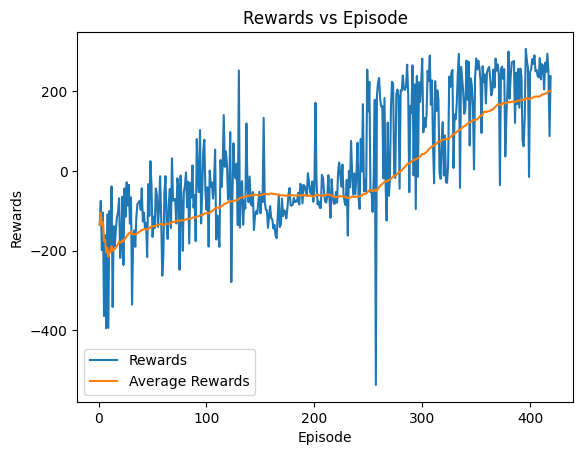

In [ ]:
# Executing the training
rewardListHuber, avgRewardListHuber = train()

# Plotting the results
episodeRange = range(1, len(rewardListHuber)+1)
plt.plot(episodeRange, rewardListHuber, label='Rewards')
plt.plot(episodeRange, avgRewardListHuber, label='Average Rewards')

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards vs Episode')
plt.legend()
plt.show()

### Executing the program with MSE Loss Function

In [ ]:
# MSE Loss
class Agent:

    def __init__(self, alpha, gamma, stepUpdate, stateSpace, actionSpace, batchSize, epsMin, epsDecay, softUpdate):

        self.optimizer = Adam(learning_rate=alpha)
        self.gamma = gamma
        self.stepUpdate = stepUpdate
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.batchSize = batchSize
        self.hiddenActivation = "relu"
        self.outputActivation = "linear"
        self.model, self.targetModel = self._createModels()
        self.targetModel.set_weights(self.model.get_weights())
        self.epsMin = epsMin
        self.epsDecay = epsDecay
        self.softUpdate = softUpdate

    # Creating a model and a target model
    def _createModels(self):
        model = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        targetModel = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        return model, targetModel

    def computeLoss(self, events):
        states, actions, rewards, nextStates, dones = events

        # Computes the max Q value of the next state
        maxQ = tf.reduce_max(self.targetModel(nextStates), axis=-1)

        # Bellman Equation
        yPred = rewards + (self.gamma * maxQ * (1-dones))
        qValues = self.model(states)

        # Selects qValues at the index of the corresponding action
        batch_size = tf.shape(qValues)[0]
        action_indices = tf.stack([tf.range(batch_size), tf.cast(actions, tf.int32)], axis=1)
        qValues = tf.gather_nd(qValues, action_indices)

        # Selected loss function
        loss = MSE(yPred, qValues)

        return loss

    def updateNetwork(self):
        # Performs a soft update of the target model weights using the model weights and a softUpdate parameter
        for weightTarget, weightModel in zip(self.targetModel.weights, self.model.weights):
            newWeight = self.softUpdate * weightModel + (1.0-self.softUpdate) * weightTarget
            weightTarget.assign(newWeight)

    # Updates the weights based on batches of events
    def fitting(self, events):
        # Automatic computation of gradients to update the weights 
        with tf.GradientTape() as tape:
            loss = self.computeLoss(events)
        
        # Loss value computed with respect to trainable variables
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.updateNetwork()

    # Decreases exploration rate as the agent becomes more experienced
    def updateEps(self, eps):
      return max(self.epsMin, self.epsDecay * eps)

Episode 100 | Total point average of the last 100 episodes: -151.57
Episode 200 | Total point average of the last 100 episodes: -93.63
Episode 300 | Total point average of the last 100 episodes: -54.39
Episode 400 | Total point average of the last 100 episodes: 38.35
Episode 500 | Total point average of the last 100 episodes: 50.61
Episode 600 | Total point average of the last 100 episodes: 180.63
Environment solved in 626 episodes!


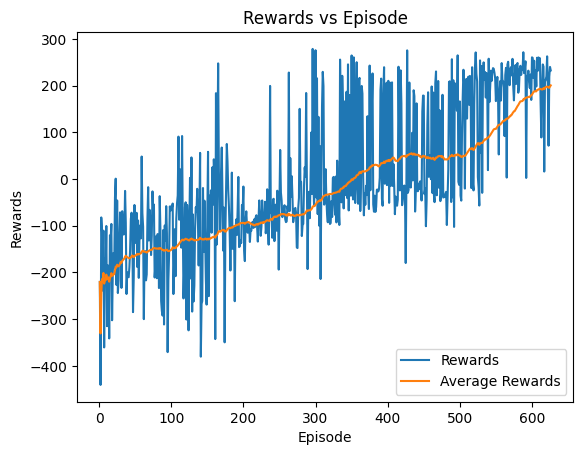

In [ ]:
# Executing the training
rewardListMSE, avgRewardListMSE = train()

# Plotting the results
episodeRange = range(1, len(rewardListMSE)+1)
plt.plot(episodeRange, rewardListMSE, label='Rewards')
plt.plot(episodeRange, avgRewardListMSE, label='Average Rewards')

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards vs Episode')
plt.legend()
plt.show()

### It is seen that the program that uses Huber Loss is able to achieve the goal significantly quicker than the code that uses MSE loss. Hence in the subsequent testing, the Huber Loss will be used and tested for various learning rates alphas = [0.01, 0.001, 0.0001]

### Modifying and executing the agent and training function to test the different learning rates

Environment alpha = 0.01 solved in 812 episodes
Environment alpha = 0.001 solved in 709 episodes
Environment alpha = 0.0001 solved in 978 episodes


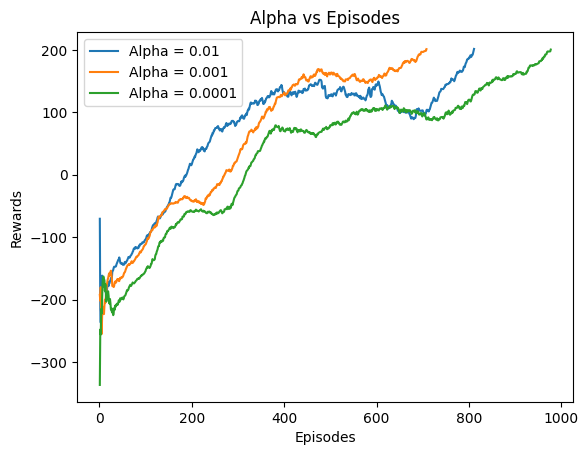

In [ ]:
# Testing learning rates
class Agent:

    def __init__(self, alpha, gamma, stepUpdate, stateSpace, actionSpace, batchSize, epsMin, epsDecay, softUpdate):

        self.optimizer = Adam(learning_rate=alpha)
        self.gamma = gamma
        self.stepUpdate = stepUpdate
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.batchSize = batchSize
        self.hiddenActivation = "relu"
        self.outputActivation = "linear"
        self.model, self.targetModel = self._createModels()
        self.targetModel.set_weights(self.model.get_weights())
        self.epsMin = epsMin
        self.epsDecay = epsDecay
        self.softUpdate = softUpdate

    # Creating a model and a target model
    def _createModels(self):
        model = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        targetModel = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        return model, targetModel

    def computeLoss(self, events):
        states, actions, rewards, nextStates, dones = events

        # Computes the max Q value of the next state
        maxQ = tf.reduce_max(self.targetModel(nextStates), axis=-1)

        # Bellman Equation
        yPred = rewards + (self.gamma * maxQ * (1-dones))
        qValues = self.model(states)

        # Selects qValues at the index of the corresponding action
        batch_size = tf.shape(qValues)[0]
        action_indices = tf.stack([tf.range(batch_size), tf.cast(actions, tf.int32)], axis=1)
        qValues = tf.gather_nd(qValues, action_indices)

        # Selected loss function
        h = tf.keras.losses.Huber()
        loss = h(yPred, qValues)

        return loss

    def updateNetwork(self):
        # Performs a soft update of the target model weights using the model weights and a softUpdate parameter
        for weightTarget, weightModel in zip(self.targetModel.weights, self.model.weights):
            newWeight = self.softUpdate * weightModel + (1.0-self.softUpdate) * weightTarget
            weightTarget.assign(newWeight)

    # Updates the weights based on batches of events
    def fitting(self, events):
        # Automatic computation of gradients to update the weights 
        with tf.GradientTape() as tape:
            loss = self.computeLoss(events)
        
        # Loss value computed with respect to trainable variables
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.updateNetwork()

    # Decreases exploration rate as the agent becomes more experienced
    def updateEps(self, eps):
      return max(self.epsMin, self.epsDecay * eps)


# Main training function
def train(alpha):
    # Initializing the parameters
    numEpisodes = 2000
    timesteps = 1000
    eps = 1.0
    gamma = 0.99
    numSteps = 4
    memorySize = 100000
    batchSize = 64
    epsMin = 0.01
    epsDecay = 0.99
    softUpdate = 0.001
    memoryBuffer = deque(maxlen=memorySize)

    # Initializing the reward list for plotting
    rewardList = []
    avgRewardList = []

    # Initializing the environment
    env = gym.make("LunarLander-v2")
    env.reset()

    # Initializing the classes
    stateSpace = env.observation_space.shape
    actionSpace = env.action_space.n

    agent = Agent(alpha=alpha, gamma=gamma, stepUpdate=numSteps, stateSpace=stateSpace, actionSpace=actionSpace, 
                  batchSize=batchSize, epsMin=epsMin, epsDecay=epsDecay, softUpdate=softUpdate)
    
    lunar = Lunar(memorySize=memorySize, stateSpace=stateSpace, actionSpace=actionSpace, batchSize=batchSize)

    # Executing the training phase
    for episode in range(numEpisodes):
        state = env.reset()
        totalRewards = 0

        for timestep in range(timesteps):
            stateQ = np.expand_dims(state, axis=0)
            qValues = agent.model(stateQ)
            action = lunar.selectActions(qValues, eps)
            nextState, reward, done, _ = env.step(action)

            # Store the experiences events into the buffer
            memoryBuffer.append(lunar.event(state, action, reward, nextState, done))

            # Check for updates
            update = lunar.updateFlag(episode, numSteps, memoryBuffer)

            if update:
                # Does the model update
                eventBuffer = random.sample(memoryBuffer, batchSize)
                events = lunar.getEvent(eventBuffer)
                agent.fitting(events)

            state = nextState.copy()
            totalRewards += reward

            if done:
                break

        rewardList.append(totalRewards)
        avgReward = np.mean(rewardList[-100:])
        avgRewardList.append(avgReward)

        eps = agent.updateEps(eps)

        # Print statement for every 100 episodes
        if (episode+1) % 100 == 0:
            print("Average of last 100 episodes: {:.2f}".format(avgReward))

        if(avgReward >= 200):
            print("Environment alpha = {} solved in {} episodes".format(alpha, len(value[1])+1))
            return rewardList, avgRewardList
    
    print("Game was not solved within {} episodes for alpha = {}".format(2000, alpha))
    return rewardList, avgRewardList
        

alphaDict = {}
alphas = [0.01, 0.001, 0.0001]
maxEpisodes = 0

for alpha in alphas:
  print("Executing alpha = {}".format(alpha))
  rewardListHuber, avgRewardListHuber = train(alpha)
  alphaList = [rewardListHuber,avgRewardListHuber]
  alphaDict[alpha] = alphaList

  episodeLength = len(rewardListHuber)

  if episodeLength > maxEpisodes:
    maxEpisodes = episodeLength

# Initialize the figure and axes
fig, ax = plt.subplots()

# Loop through the dictionary and plot each graph
for key, value in alphaDict.items():
    episodeRange = range(1, len(value[1])+1)
    avgRewards = value[1]
    ax.plot(episodeRange, avgRewards, label= f'Alpha = {key}')

# Add legend, title, and axis labels
ax.legend()
ax.set_title('Alpha vs Episodes')
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')

# Show the plot
plt.show()

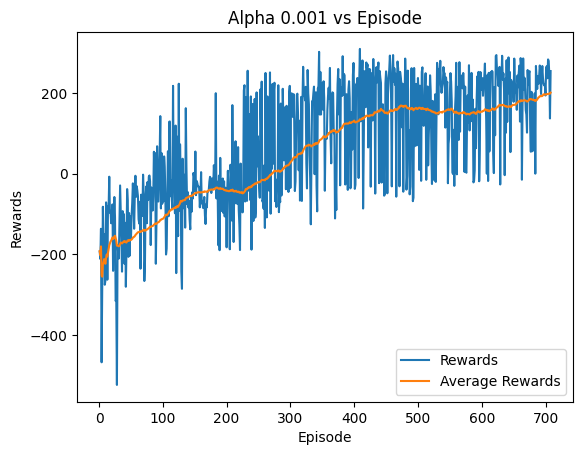

In [ ]:
# Visualising the reward and average rewards of alpha = 0.001
finalAlpha = alphaDict.get('0.001')

# Plotting the results
episodeRange = range(1, len(finalAlpha[1])+1)
rewardList = finalAlpha[0]
avgReward = finalAlpha[1]
plt.plot(episodeRange, rewardList, label='Rewards')
plt.plot(episodeRange, avgReward, label='Average Rewards')

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Alpha 0.001 vs Episode')
plt.legend()
plt.show()

### It is shown that the game is solved the quickest when a learning rate alpha = 0.001 is used. The final test is to determine the starting eps value in solving the game.

### Modifying and executing the agent and training helper function to test the various eps starting values

Environment eps = 0.1 solved in 944 episodes
Environment eps = 1 solved in 554 episodes
Environment eps = 0.01 solved in 766 episodes


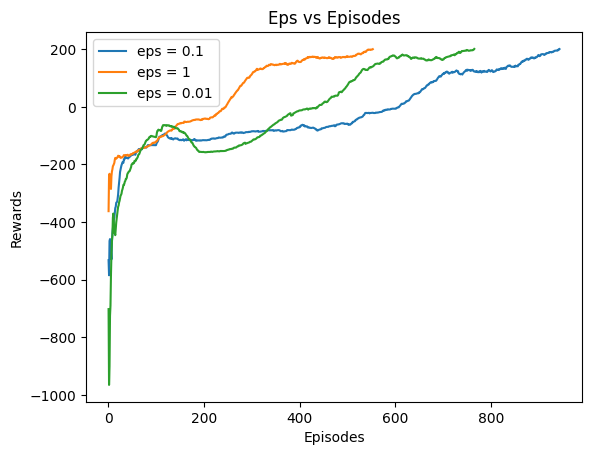

In [ ]:
# Testing eps values
class Agent:

    def __init__(self, alpha, gamma, stepUpdate, stateSpace, actionSpace, batchSize, epsMin, epsDecay, softUpdate):

        self.optimizer = Adam(learning_rate=alpha)
        self.gamma = gamma
        self.stepUpdate = stepUpdate
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.batchSize = batchSize
        self.hiddenActivation = "relu"
        self.outputActivation = "linear"
        self.model, self.targetModel = self._createModels()
        self.targetModel.set_weights(self.model.get_weights())
        self.epsMin = epsMin
        self.epsDecay = epsDecay
        self.softUpdate = softUpdate

    # Creating a model and a target model
    def _createModels(self):
        model = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        targetModel = Sequential([
                Input(shape=self.stateSpace),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.batchSize, activation=self.hiddenActivation),
                Dense(self.actionSpace, activation=self.outputActivation)])

        return model, targetModel

    def computeLoss(self, events):
        states, actions, rewards, nextStates, dones = events

        # Computes the max Q value of the next state
        maxQ = tf.reduce_max(self.targetModel(nextStates), axis=-1)

        # Bellman Equation
        yPred = rewards + (self.gamma * maxQ * (1-dones))
        qValues = self.model(states)

        # Selects qValues at the index of the corresponding action
        batch_size = tf.shape(qValues)[0]
        action_indices = tf.stack([tf.range(batch_size), tf.cast(actions, tf.int32)], axis=1)
        qValues = tf.gather_nd(qValues, action_indices)

        # Selected loss function
        h = tf.keras.losses.Huber()
        loss = h(yPred, qValues)

        return loss

    def updateNetwork(self):
        # Performs a soft update of the target model weights using the model weights and a softUpdate parameter
        for weightTarget, weightModel in zip(self.targetModel.weights, self.model.weights):
            newWeight = self.softUpdate * weightModel + (1.0-self.softUpdate) * weightTarget
            weightTarget.assign(newWeight)

    # Updates the weights based on batches of events
    def fitting(self, events):
        # Automatic computation of gradients to update the weights 
        with tf.GradientTape() as tape:
            loss = self.computeLoss(events)
        
        # Loss value computed with respect to trainable variables
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.updateNetwork()

    # Decreases exploration rate as the agent becomes more experienced
    def updateEps(self, eps):
      return max(self.epsMin, self.epsDecay * eps)


# Main training function
def train(eps):
    # Initializing the parameters
    numEpisodes = 2000
    timesteps = 1000
    alpha = 0.001
    gamma = 0.99
    numSteps = 4
    memorySize = 100000
    batchSize = 64
    epsMin = 0.01
    epsDecay = 0.99
    softUpdate = 0.001
    memoryBuffer = deque(maxlen=memorySize)

    # Initializing the reward list for plotting
    rewardList = []
    avgRewardList = []

    # Initializing the environment
    env = gym.make("LunarLander-v2")
    env.reset()

    # Initializing the classes
    stateSpace = env.observation_space.shape
    actionSpace = env.action_space.n

    agent = Agent(alpha=alpha, gamma=gamma, stepUpdate=numSteps, stateSpace=stateSpace, actionSpace=actionSpace, 
                  batchSize=batchSize, epsMin=epsMin, epsDecay=epsDecay, softUpdate=softUpdate)
    
    lunar = Lunar(memorySize=memorySize, stateSpace=stateSpace, actionSpace=actionSpace, batchSize=batchSize)

    # Executing the training phase
    for episode in range(numEpisodes):
        state = env.reset()
        totalRewards = 0

        for timestep in range(timesteps):
            stateQ = np.expand_dims(state, axis=0)
            qValues = agent.model(stateQ)
            action = lunar.selectActions(qValues, eps)
            nextState, reward, done, _ = env.step(action)

            # Store the experiences events into the buffer
            memoryBuffer.append(lunar.event(state, action, reward, nextState, done))

            # Check for updates
            update = lunar.updateFlag(episode, numSteps, memoryBuffer)

            if update:
                # Does the model update
                eventBuffer = random.sample(memoryBuffer, batchSize)
                events = lunar.getEvent(eventBuffer)
                agent.fitting(events)

            state = nextState.copy()
            totalRewards += reward

            if done:
                break

        rewardList.append(totalRewards)
        avgReward = np.mean(rewardList[-100:])
        avgRewardList.append(avgReward)

        eps = agent.updateEps(eps)

        # Print statement for every 100 episodes
        if (episode+1) % 100 == 0:
            print("Average of last 100 episodes: {:.2f}".format(avgReward))

        if(avgReward >= 200):
            print("Environment eps = {} solved in {} episodes".format(eps, len(value[1])+1))
            return rewardList, avgRewardList
    
    print("Game was not solved within {} episodes for eps = {}".format(numEpisodes, eps))
    return rewardList, avgRewardList
        

epsDict = {}
# alpha = 0.01 maxed out the number of episodes
epsTrials = [1, 0.1, 0.01]
maxEpisodes = 0

for eps in epsTrials:
  print("Executing starting eps = {}".format(eps))
  rewardListHuber, avgRewardListHuber = train(eps)
  epsList = [rewardListHuber,avgRewardListHuber]
  epsDict[eps] = epsList

  episodeLength = len(rewardListHuber)

  if episodeLength > maxEpisodes:
    maxEpisodes = episodeLength

# Initialize the figure and axes
fig, ax = plt.subplots()

# Loop through the dictionary and plot each graph
for key, value in epsDict.items():
    episodeRange = range(1, len(value[1])+1)
    avgRewards = value[1]
    ax.plot(episodeRange, avgRewards, label= f'eps = {key}')

# Add legend, title, and axis labels
ax.legend()
ax.set_title('Eps vs Episodes')
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')

# Show the plot
plt.show()

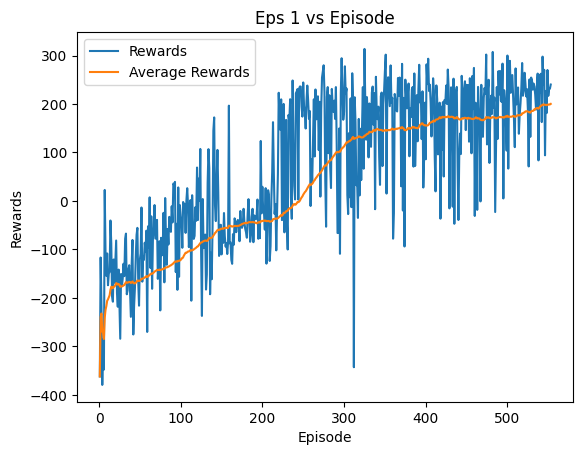

In [ ]:
# Visualising the reward and average rewards of eps = 1
finaleps = epsDict.get('1')

# Plotting the results
episodeRange = range(1, len(finaleps[1])+1)
rewardList = finaleps[0]
avgReward = finaleps[1]
plt.plot(episodeRange, rewardList, label='Rewards')
plt.plot(episodeRange, avgReward, label='Average Rewards')

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Eps 1 vs Episode')
plt.legend()
plt.show()

### Hence, the best model tested is using Huber loss with learning rate alpha = 0.001 and a starting eps = 1.0. The following cell is the finalised code with all the optimized hyperparameters tested

# Final Model

In [ ]:
# Final Model

import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import Huber, MSE
from collections import deque, namedtuple

tf.random.set_seed(0)

class Lunar:

    def __init__(self, memorySize, stateSpace, actionSpace, batchSize):

        self.env = gym.make("LunarLander-v2")
        self.stateSpace = stateSpace
        self.actionSpace = actionSpace
        self.event = namedtuple("Experience", field_names=["state", "action", "reward", "nextState", "done"])
        self.memoryBuffer = deque(range(memorySize))
        self.batchSize = batchSize

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def selectActions(self, qValues, eps):
        if random.random() > eps:
            return np.argmax(qValues.numpy()[0])
        else:
            return random.choice(np.arange(self.actionSpace))

    def updateFlag(self, currentStep, stepUpdate, memoryBuffer):
        # Ensures model not updated too frequently
        # Ensure buffer greater than batchsize such that enough experience to sample from for training
        if(currentStep+1) % stepUpdate == 0 and len(memoryBuffer) > self.batchSize:
            return True
        else:
            return False

    def getEvent(self, events):
        # Extract the states, actions, rewards, nextStates, and dones from a list of events
        # Only extract the values for non-None events
        states = tf.convert_to_tensor(np.array([e.state for e in events if e is not None]),dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array([e.action for e in events if e is not None]), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array([e.reward for e in events if e is not None]), dtype=tf.float32)
        nextStates = tf.convert_to_tensor(np.array([e.nextState for e in events if e is not None]),dtype=tf.float32)

        # Indicates if the episode is over or not
        dones = tf.convert_to_tensor(np.array([e.done for e in events if e is not None]).astype(np.uint8), dtype=tf.float32)

        return (states, actions, rewards, nextStates, dones)
  
class Agent:

  def __init__(self, alpha, gamma, stepUpdate, stateSpace, actionSpace, batchSize, epsMin, epsDecay, softUpdate):

      self.optimizer = Adam(learning_rate=alpha)
      self.gamma = gamma
      self.stepUpdate = stepUpdate
      self.stateSpace = stateSpace
      self.actionSpace = actionSpace
      self.batchSize = batchSize
      self.hiddenActivation = "relu"
      self.outputActivation = "linear"
      self.model, self.targetModel = self._createModels()
      self.targetModel.set_weights(self.model.get_weights())
      self.epsMin = epsMin
      self.epsDecay = epsDecay
      self.softUpdate = softUpdate

  # Creating a model and a target model
  def _createModels(self):
      model = Sequential([
              Input(shape=self.stateSpace),
              Dense(self.batchSize, activation=self.hiddenActivation),
              Dense(self.batchSize, activation=self.hiddenActivation),
              Dense(self.actionSpace, activation=self.outputActivation)])

      targetModel = Sequential([
              Input(shape=self.stateSpace),
              Dense(self.batchSize, activation=self.hiddenActivation),
              Dense(self.batchSize, activation=self.hiddenActivation),
              Dense(self.actionSpace, activation=self.outputActivation)])

      return model, targetModel

  def computeLoss(self, events):
      states, actions, rewards, nextStates, dones = events

      # Computes the max Q value of the next state
      maxQ = tf.reduce_max(self.targetModel(nextStates), axis=-1)

      # Bellman Equation
      yPred = rewards + (self.gamma * maxQ * (1-dones))
      qValues = self.model(states)

      # Selects qValues at the index of the corresponding action
      batch_size = tf.shape(qValues)[0]
      action_indices = tf.stack([tf.range(batch_size), tf.cast(actions, tf.int32)], axis=1)
      qValues = tf.gather_nd(qValues, action_indices)

      # Selected loss function
      h = tf.keras.losses.Huber()
      loss = h(yPred, qValues)

      return loss

  def updateNetwork(self):
      # Performs a soft update of the target model weights using the model weights and a softUpdate parameter
      for weightTarget, weightModel in zip(self.targetModel.weights, self.model.weights):
          newWeight = self.softUpdate * weightModel + (1.0-self.softUpdate) * weightTarget
          weightTarget.assign(newWeight)

  # Updates the weights based on batches of events
  def fitting(self, events):
      # Automatic computation of gradients to update the weights 
      with tf.GradientTape() as tape:
          loss = self.computeLoss(events)
      
      # Loss value computed with respect to trainable variables
      gradients = tape.gradient(loss, self.model.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

      self.updateNetwork()

  # Decreases exploration rate as the agent becomes more experienced
  def updateEps(self, eps):
    return max(self.epsMin, self.epsDecay * eps)

# Main training function
def train():
    # Initializing the parameters
    numEpisodes = 2000
    timesteps = 1000
    eps = 1.0
    alpha = 0.001
    gamma = 0.99
    numSteps = 4
    memorySize = 100000
    batchSize = 64
    epsMin = 0.01
    epsDecay = 0.99
    softUpdate = 0.001
    memoryBuffer = deque(maxlen=memorySize)

    # Initializing the reward list for plotting
    rewardList = []
    avgRewardList = []

    # Initializing the environment
    env = gym.make("LunarLander-v2")
    env.reset()

    # Initializing the classes
    stateSpace = env.observation_space.shape
    actionSpace = env.action_space.n

    agent = Agent(alpha=alpha, gamma=gamma, stepUpdate=numSteps, stateSpace=stateSpace, actionSpace=actionSpace, 
                  batchSize=batchSize, epsMin=epsMin, epsDecay=epsDecay, softUpdate=softUpdate)
    
    lunar = Lunar(memorySize=memorySize, stateSpace=stateSpace, actionSpace=actionSpace, batchSize=batchSize)

    # Executing the training phase
    for episode in range(numEpisodes):
        state = env.reset()
        totalRewards = 0

        for timestep in range(timesteps):
            stateQ = np.expand_dims(state, axis=0)
            qValues = agent.model(stateQ)
            action = lunar.selectActions(qValues, eps)
            nextState, reward, done, _ = env.step(action)

            # Store the experiences events into the buffer
            memoryBuffer.append(lunar.event(state, action, reward, nextState, done))

            # Check for updates
            update = lunar.updateFlag(episode, numSteps, memoryBuffer)

            if update:
                # Does the model update
                eventBuffer = random.sample(memoryBuffer, batchSize)
                events = lunar.getEvent(eventBuffer)
                agent.fitting(events)

            state = nextState.copy()
            totalRewards += reward

            if done:
                break

        rewardList.append(totalRewards)
        avgReward = np.mean(rewardList[-100:])
        avgRewardList.append(avgReward)

        eps = agent.updateEps(eps)

        # Print statement for every 100 episodes
        if (episode+1) % 100 == 0:
            print("Average of last 100 episodes: {:.2f}".format(avgReward))

        if(avgReward >= 200):
            print("Environment solved in {} episodes with average reward {:.2f}".format(episode+1,avgReward))
            return rewardList, avgRewardList

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Average of last 100 episodes: -112.78
Average of last 100 episodes: -29.52
Average of last 100 episodes: 98.32
Average of last 100 episodes: 171.90
Environment solved in 448 episodes with average reward 200.06


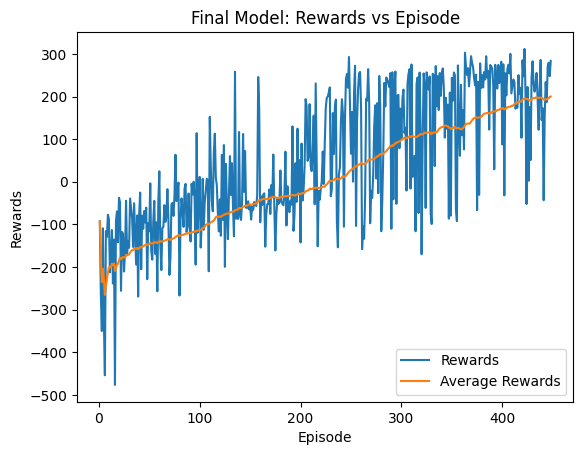

In [ ]:
# Executing the training
rewardList, avgRewardList = train()

# Plotting the results
episodeRange = range(1, len(rewardList)+1)
plt.plot(episodeRange, rewardList, label='Rewards')
plt.plot(episodeRange, avgRewardList, label='Average Rewards')

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Final Model: Rewards vs Episode')
plt.legend()
plt.show()